# Import Libraries


In [ ]:
import numpy as np
import cv2
import os
from skimage.filters import threshold_local
import imutils
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import HTML

## Upload an image from computer

In [ ]:
#@markdown <h1> 🖼️ เลือกรูปภาพ Choose An Image</h1>
#@markdown <small>อัพโหลดรูปภาพจากไฟล์ในคอมพิวเตอร์ของคุณ</small>
display(HTML('<h3>Select your image</h3>'))
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving ReceiptSwiss.jpg to ReceiptSwiss.jpg
User uploaded file "ReceiptSwiss.jpg" with length 962613 bytes


##Read the image and resize the image

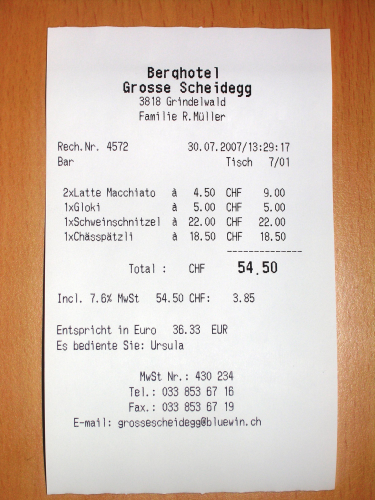

In [ ]:
img = cv2.imread(fn) # Read input
ratio = img.shape[0] / 500.0
orig = img.copy() # Copy image
img = imutils.resize(img, height=500)

cv2_imshow(img)

#หาขอบกระดาษจากรูปภาพ
1. แปลงภาพสีให้เป็นภาพขาวดำ
2. ตัด noise โดยวิธี gaussian blur
3. ใช้ Canny Edge หาขอบภาพ
4. ทำการ dilate และ erosion จากที่ทำ canny edge
 

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # RGB to gray
gaussian = cv2.GaussianBlur(gray, (5, 5), 0) # Gaussian Blur
edges = cv2.Canny(gaussian, 75, 200) # Edge detection

Gray Image


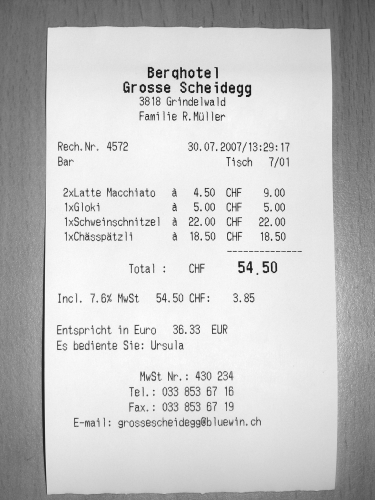

In [ ]:
print("Gray Image")
cv2_imshow(gray)

Gaussian Image


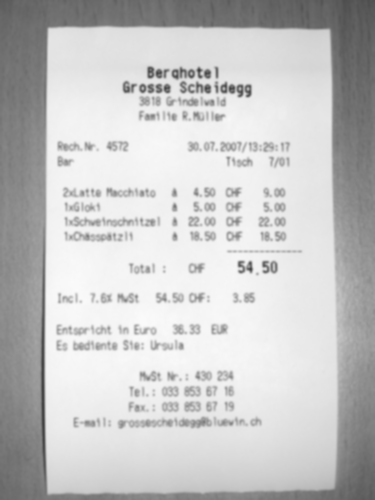

In [ ]:
print("Gaussian Image")
cv2_imshow(gaussian)

In [ ]:
kernel = np.ones((5,5), np.uint8)
dilate = cv2.dilate(edges, kernel, iterations=2)
edges = cv2.erode(dilate, kernel, iterations=1)

Dilation


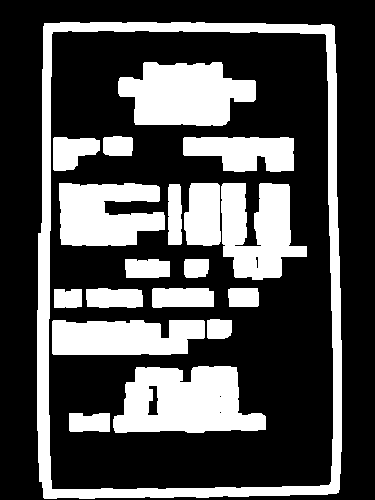

In [ ]:
print("Dilation")
cv2_imshow(dilate)

Canny Edge


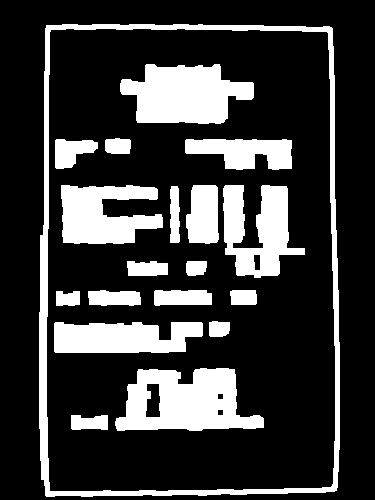

In [ ]:
print("Canny Edge")
cv2_imshow(edges)

#Finding Contours

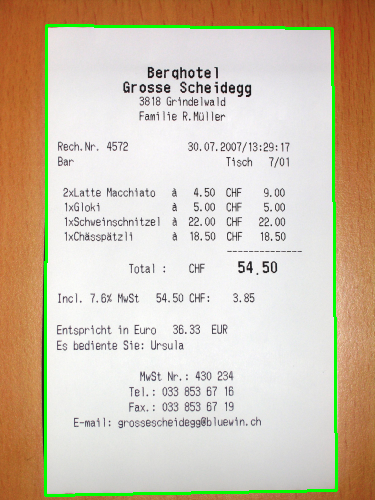

In [ ]:
contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)

# go through each contour
for contour in contours:
    # we approximate the contour
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
    if len(approx) == 4:
        cnts = approx
        break

cv2.drawContours(img, [cnts], -1, (0, 255, 0), 2)
cv2_imshow(img)

#Perspective Transform

In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    summ = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(summ)]
    rect[2] = pts[np.argmax(summ)]

    difference = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(difference)]
    rect[3] = pts[np.argmax(difference)]
    
    return rect

In [ ]:
def four_point_transform(img, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    width1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width2 = np.sqrt(((tr[0] - tl[0]) ** 2) +((tr[1] - tl[1]) ** 2))
    Width = max(int(width1), int(width2)) #considers maximum width value as Width

    height1 = np.sqrt(((tr[0] - br[0]) ** 2) +((tr[1] - br[1]) ** 2))
    height2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    Height = max(int(height1), int(height2)) #considers maximum height value as Height

    distance = np.array([[0, 0],[Width - 1, 0],[Width - 1, Height - 1],[0,Height - 1]], dtype ="float32")
    matrix = cv2.getPerspectiveTransform(rect, distance) 
    warped = cv2.warpPerspective(img, matrix, (Width, Height))

    return warped

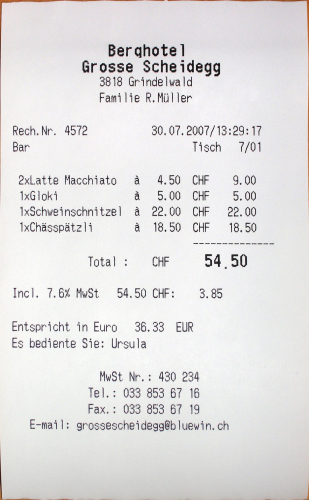

In [ ]:
warped = four_point_transform(orig, cnts.reshape(4,2) * ratio)

cv2_imshow(imutils.resize(warped, height=500))

#Features เสริม

#OCR

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#แปลงรูปให้เป็น text

In [ ]:
import pytesseract

text = pytesseract.image_to_string(warped, lang='eng')
print("Text Detected: \n"+text)

Text Detected: 
 

Ber ghote |

Grosse Scheidegg
3818 Grindelwald

Familie R. Muller

Rech.Nr. 45/2 30,07. 2007/ 13723519
Bar Tisch . G7

exLatte Macchiato a 4.50 CHF 9. 00

IxGloki a. 5.08 CHF 5. 00

IxSchweinschnitzel a 22.00 CHF 22.00
a

16,50" CHE 1.30

ee ae SS SR NE ee se

Total : CHF a4 50

Incl. (On MWwet. OC,.G0°CHr: 3.86

IxChasspatz |i

Enteprichnt: in Euro. 36,03 EUR
Es bediente Sie: Ursula

MwSt Nr.; 480 234
Je1.4 035 Beaco, 16
Pax. : 085 6a0 Gy 18
E-mail: grossescheidegg@b luewin. ch

